In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import kl_divergence

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Bayesian
!pip install torchbnn
import torchbnn as bnn

Using cpu device


# 0. Data Preprocessing


In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

### Data description
`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019.
* `dat['spks']`: neurons by trials by time bins.    
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.


In [ ]:
dat = alldat[11]    # choose session no.11
response = dat['response']
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

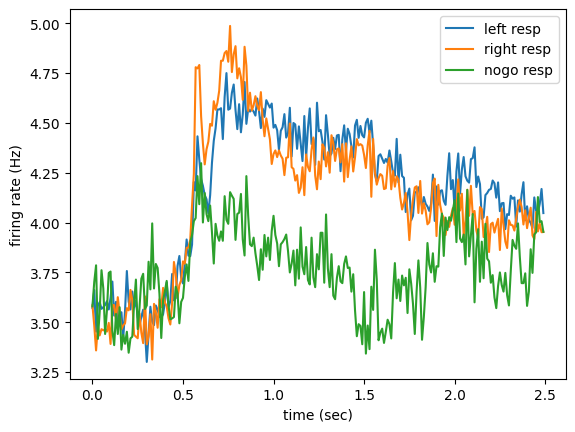

In [ ]:
# @title Basic plots of mean firing rate

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]
NN = len(dat['brain_area'])  # number of neurons

response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response > 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response == 0].mean(axis=(0, 1)))  # nogo responses

plt.legend(['left resp', 'right resp', 'nogo resp'])
plt.xlabel('time (sec)')
plt.ylabel('firing rate (Hz)')

plt.show()

In [ ]:
print(dat['spks'][:,response>0].shape)
print(dat['spks'][:,response==0].shape)
print(dat['spks'][:,response<0].shape)

(698, 135, 250)
(698, 64, 250)
(698, 141, 250)


### Calculate mean firing rate

In [ ]:
X_side = (1/dt * (dat['spks'][:][:, response != 0]).mean(axis = 2)).T  # left or right response
X_side_raw = np.transpose((1/dt * (dat['spks'][:][:, response != 0])),(1,0,2))
y_side = response[response != 0]
X_nogo = (1/dt * (dat['spks'][:][:, response == 0]).mean(axis = 2)).T # NoGo response
X_nogo_raw = np.transpose((1/dt * (dat['spks'][:][:, response == 0])),(1,0,2))
y_nogo = response[response == 0]

In [ ]:
# (n_trials, n_neurons)
print(dat['spks'].shape)
print(np.shape(X_side))
print(np.shape(X_nogo))
print(np.shape(y_side))
print(np.shape(y_nogo))

(698, 340, 250)
(276, 698)
(64, 698)
(276,)
(64,)


### Split dataset with or without NoGo Trial

In [ ]:
X_side_train, X_side_test, y_side_train, y_side_test = train_test_split(X_side, y_side, test_size = 0.2, random_state = 42, shuffle = True)
X_nogo_train, X_nogo_test, y_nogo_train, y_nogo_test = train_test_split(X_nogo, y_nogo, test_size = 0.2, random_state = 42, shuffle = True)
X_side_raw_train, X_side_raw_test, y_side_raw_train, y_side_raw_test = train_test_split(X_side_raw, y_side, test_size = 0.2, random_state = 42, shuffle = True)
X_nogo_raw_train, X_nogo_raw_test, y_nogo_raw_train, y_nogo_raw_test = train_test_split(X_nogo_raw, y_nogo, test_size = 0.2, random_state = 42, shuffle = True)

X_train = np.concatenate((X_side_train, X_nogo_train), axis=0)
y_train = np.concatenate((y_side_train, y_nogo_train), axis=0)
X_test = np.concatenate((X_side_test, X_nogo_test), axis=0)
y_test = np.concatenate((y_side_test, y_nogo_test), axis=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train_MLP = np.copy(X_side_train)
y_train_MLP = np.copy(y_side_train)
y_train_MLP[y_train_MLP<0] = 0
print(X_train_MLP.shape)
X_test_MLP = np.copy(X_side_test)
y_test_MLP = np.copy(y_side_test)
y_test_MLP[y_test_MLP<0] = 0
print(X_test_MLP.shape)

(271, 698)
(69, 698)
(271,)
(69,)
(220, 698)
(56, 698)


# 1. Generalized Linear Model

0.43333333333333335
[ 1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1.
  1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.] [ 1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.92

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.26785714285714285,
  0.17857142857142858,
  0.14285714285714285,
  0.07142857142857142,
  0.05357142857142857,
  0.05357142857142857,
  0.05357142857142857,
  0.08928571428571429,
  0.08928571428571429,
  0.07142857142857142])

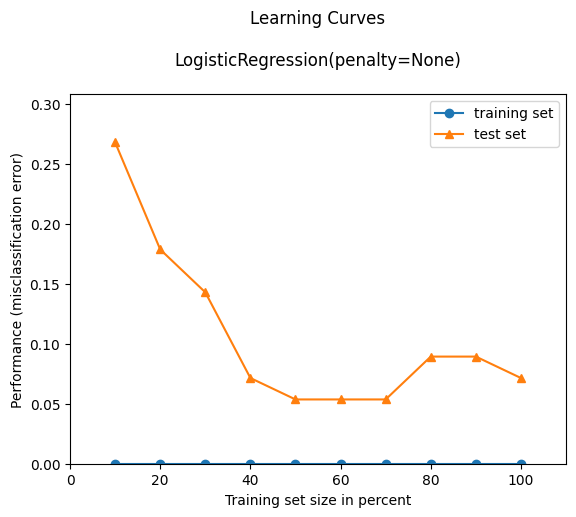

In [ ]:
# Define the model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_side_train, y_side_train)

X_test = np.concatenate((X_side_test, X_nogo), axis=0)
y_test = np.concatenate((y_side_test, y_nogo), axis=0)

y_pred = log_reg.predict(X_test)
print((y_test == y_pred).sum()/len(y_test))
print(y_pred, y_test)

y_pred = log_reg.predict(X_side_test)
print((y_side_test == y_pred).sum()/len(y_side_test))
print(y_pred, y_side_test)

y_pred = log_reg.predict(X_nogo)
print((y_nogo == y_pred).sum()/len(y_nogo))
print(y_pred, y_nogo)

plot_learning_curves(X_side_train, y_side_train, X_side_test, y_side_test, log_reg)

# 2. Multi Layer Perceptron

epoch 10 | loss on last mini-batch:  1.37e-01
epoch 20 | loss on last mini-batch:  3.34e-01
epoch 30 | loss on last mini-batch:  1.95e-02
epoch 40 | loss on last mini-batch:  6.90e-02
epoch 50 | loss on last mini-batch:  2.77e-04
training done!
0.9642857142857143
[1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 1.] [1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1.]


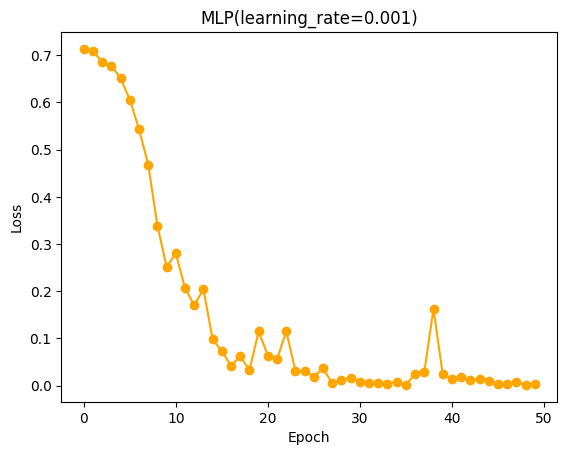

In [ ]:
# Define the model
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    c_in = 698
    dim = 256
    self.relu = nn.ReLU()
    self.dp = nn.Dropout(0.2)
    self.fc1= nn.Linear(c_in, dim)
    self.fc2= nn.Linear(dim, dim//2)
    self.fc3= nn.Linear(dim//2, dim//4)
    self.fc4= nn.Linear(dim//4, dim//8)
    self.out= nn.Linear(dim//8, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dp(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dp(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dp(x)
    x = self.fc4(x)
    x = self.relu(x)
    return torch.sigmoid(self.out(x))

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    c_in_h = 698
    c_in_w = 250
    self.relu = nn.ReLU()
    self.conv1= nn.Conv2d(1, 6, kernel_size=7, padding=3)
    self.bn1 = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(4)
    self.conv2 = nn.Conv2d(3, 9, kernel_size=7, padding=3)
    self.bn2 = nn.BatchNorm2d(9)
    self.fc = nn.Linear(6*(c_in_h//4)*(c_in_w//4),10)
    self.out= nn.Linear(10, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool(x)
    """
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool(x)
    """
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return torch.sigmoid(self.out(x))

def train(net, train_data, train_labels, n_epochs=50, learning_rate=0.001, batch_size=50):
  # Initialize binary cross-entropy loss function
  loss_fn = nn.BCELoss()

  # Initialize SGD optimizer with momentum
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    avg_loss = 0

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches

    # Loop over mini-batches
    for stimuli, label in zip(minibatch_data, minibatch_labels):
      stimuli = torch.unsqueeze(stimuli, 1)
      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      out = torch.squeeze(out)
      loss = loss_fn(out, label)  # evaluate loss
      optimizer.zero_grad()  # clear gradients
      loss.backward()  # compute gradients
      optimizer.step()  # update weights

      # Keep track of loss at each iteration
      avg_loss += loss.item()
    avg_loss /= len(minibatch_labels)
    track_loss.append(avg_loss)

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {loss.item(): .2e}')

  print('training done!')

  plt.plot(np.arange(n_epochs), track_loss,'-o',color='orange')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("MLP(learning_rate=0.001)")

model = MLP()
train(model, torch.tensor(X_train_MLP, dtype=torch.float32), torch.tensor(y_train_MLP, dtype=torch.float32))
y_pred_MLP = model(torch.tensor(X_test_MLP, dtype=torch.float32))
y_pred_MLP = np.rint(torch.squeeze(y_pred_MLP).detach().numpy())
print((y_test_MLP == y_pred_MLP).sum()/len(y_test_MLP))
print(y_pred_MLP, y_test_MLP)

# 3. Bayesian Classifier

0.36666666666666664
[ 1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1.
 -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.] [ 1.  1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.78

([0.0,
  0.0,
  0.0,
  0.011363636363636364,
  0.03636363636363636,
  0.030303030303030304,
  0.032467532467532464,
  0.03409090909090909,
  0.025252525252525252,
  0.02727272727272727],
 [0.44642857142857145,
  0.5,
  0.2857142857142857,
  0.26785714285714285,
  0.2857142857142857,
  0.30357142857142855,
  0.23214285714285715,
  0.23214285714285715,
  0.25,
  0.21428571428571427])

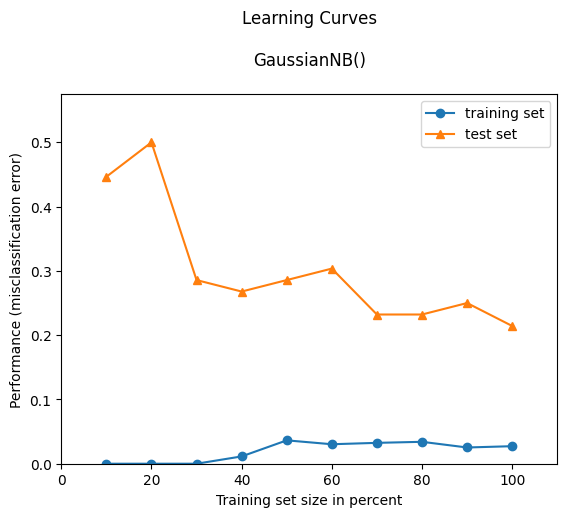

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_side_train, y_side_train)

X_test = np.concatenate((X_side_test, X_nogo), axis=0)
y_test = np.concatenate((y_side_test, y_nogo), axis=0)

y_pred = gnb.predict(X_test)
print((y_test == y_pred).sum()/len(y_test))
print(y_pred, y_test)

y_pred = gnb.predict(X_side_test)
print((y_side_test == y_pred).sum()/len(y_side_test))
print(y_pred, y_side_test)

y_pred = gnb.predict(X_nogo)
print((y_nogo == y_pred).sum()/len(y_nogo))
print(y_pred, y_nogo)

plot_learning_curves(X_side_train, y_side_train, X_side_test, y_side_test, gnb)

# 4. Bayesian MLP

In [ ]:
def train(net, train_data, train_labels, n_epochs=50, learning_rate=0.001, batch_size=50):

  ce_loss = nn.BCELoss()
  kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
  kl_weight = 0.1
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):
    total = 0
    correct = 0
    avg_loss = 0

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches

    # Loop over mini-batches
    for stimuli, label in zip(minibatch_data, minibatch_labels):
      stimuli = torch.unsqueeze(stimuli, 1)
      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      out = torch.squeeze(out)
      ce = ce_loss(out, label)
      kl = kl_loss(net)
      cost = ce + kl_weight*kl
      optimizer.zero_grad()
      cost.backward()
      optimizer.step()
      # Keep track of loss at each iteration
      avg_loss += cost.item()
    avg_loss /= len(minibatch_labels)
    track_loss.append(avg_loss)

    # Track progress
    if (i + 1) % (n_epochs // 10) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {cost.item(): .2e}')

  print('training done!')

  plt.plot(np.arange(n_epochs), track_loss,color='skyblue')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Bayesian MLP(learning_rate=0.001)")

epoch 200 | loss on last mini-batch:  8.17e-01
epoch 400 | loss on last mini-batch:  7.22e-01
epoch 600 | loss on last mini-batch:  7.06e-01
epoch 800 | loss on last mini-batch:  6.97e-01
epoch 1000 | loss on last mini-batch:  6.98e-01
epoch 1200 | loss on last mini-batch:  6.97e-01
epoch 1400 | loss on last mini-batch:  3.37e-01
epoch 1600 | loss on last mini-batch:  4.98e-01
epoch 1800 | loss on last mini-batch:  3.75e-01
epoch 2000 | loss on last mini-batch:  1.18e-01
training done!


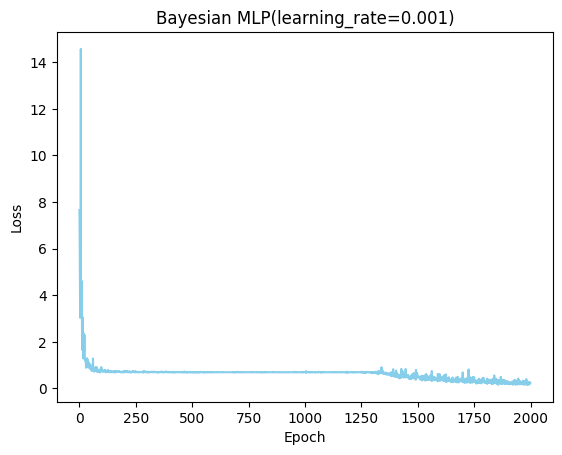

In [ ]:
c_in = 698
dim = 256

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=c_in, out_features=dim),
    nn.ReLU(),
    nn.Dropout(0.2),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=dim, out_features=dim//2),
    nn.ReLU(),
    nn.Dropout(0.2),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=dim//2, out_features=dim//4),
    nn.ReLU(),
    nn.Dropout(0.2),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=dim//4, out_features=dim//8),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=dim//8, out_features=1),
    nn.Sigmoid()
)

y_train_Bayes_np = np.copy(y_side_train)
y_train_Bayes_np[y_train_Bayes_np<0] = 0
y_test_Bayes_np = np.copy(y_side_test)
y_test_Bayes_np[y_test_Bayes_np<0] = 0

X_train_Bayes = torch.tensor(X_side_train, dtype=torch.float32)
y_train_Bayes = torch.tensor(y_train_Bayes_np, dtype=torch.float32)

train(model, X_train_Bayes, y_train_Bayes,n_epochs=2000, learning_rate=0.001)

In [ ]:
X_side_test_Bayes = torch.tensor(X_side_test, dtype=torch.float32)
y_side_test_Bayes = torch.tensor(y_test_Bayes_np, dtype=torch.float32)

y_pred_Bayes = model(X_side_test_Bayes)
y_pred_Bayes = np.rint(torch.squeeze(y_pred_Bayes).detach().numpy())
print((y_test_Bayes_np == y_pred_Bayes).sum()/len(y_test_Bayes_np))
print(y_test_Bayes_np, y_pred_Bayes)

0.875
[1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1.] [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 1.]


In [ ]:
X_nogo_test_Bayes = torch.tensor(X_nogo, dtype=torch.float32)
y_nogo_Bayes = torch.tensor(y_nogo, dtype=torch.float32)

y_pred_Bayes = model(X_nogo_test_Bayes)
y_pred_Bayes = np.rint(torch.squeeze(y_pred_Bayes).detach().numpy())

print(y_nogo, y_pred_Bayes)
print((y_nogo == y_pred_Bayes).sum()/len(y_nogo))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
0.828125


# Supplement 1. Bayesian CNN
**Note that the following model takes around 1hr 40min for training.**

In [ ]:
# Define Bayesian Convolutional Layer
class BayesianConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, priors=None):
        super(BayesianConv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.kl = 0
        if priors is None:
            priors = {
                'prior_mean': 0,
                'prior_stddev': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mean = priors['prior_mean']
        self.prior_stddev = priors['prior_stddev']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Learnable parameters for mean and standard deviation
        self.weight_mean = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.weight_stddev = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        self.reset_parameters()

    def reset_parameters(self):
        self.weight_mean.data.normal_(*self.posterior_mu_initial)
        self.weight_stddev.data.normal_(*self.posterior_rho_initial)

    def kl_loss(self):
        prior = Normal(self.prior_mean, F.softplus(torch.tensor(self.prior_stddev).clone().detach()))
        posterior = Normal(self.weight_mean, F.softplus(self.weight_stddev.clone().detach()))
        kl = kl_divergence(posterior, prior)
        self.kl = kl

    def forward(self, x):
        if self.training:
          W_eps = torch.empty(self.weight_mean.size()).normal_(0, 1).to(self.device)
          self.W_sigma = torch.log1p(torch.exp(self.weight_stddev))
          weight = self.weight_mean + W_eps * self.W_sigma
        else:
            weight = self.weight_mean
        self.kl_loss()
        return F.conv2d(x, weight, padding=self.padding)

# Define the model
class BayesianCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = BayesianConv2D(1, 32, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu = nn.ReLU()
    self.conv2 = BayesianConv2D(32, 1, 3, padding=1)
    self.bn2 = nn.BatchNorm2d(1)
    self.fc = nn.Linear(698*250, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x

def train(net, train_data, train_labels, n_epochs=100, learning_rate=0.001, batch_size=50):
  # Initialize cross-entropy loss function
  criterion = nn.KLDivLoss(reduction='batchmean')

  # Initialize SGD optimizer with momentum
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  # Placeholder to save loss at each iteration
  track_loss = []

  # Loop over epochs
  for i in range(n_epochs):
    avg_loss = 0

    # Split up training data into random non-overlapping mini-batches
    ishuffle = torch.randperm(train_data.shape[0])  # random ordering of training data
    minibatch_data = torch.split(train_data[ishuffle], batch_size)  # split train_data into minibatches
    minibatch_labels = torch.split(train_labels[ishuffle], batch_size)  # split train_labels into minibatches
    # Loop over mini-batches
    for stimuli, label in zip(minibatch_data, minibatch_labels):
      stimuli = torch.unsqueeze(stimuli, 1)
      # Evaluate loss and update network weights
      out = net(stimuli)  # predicted probability of tilt right
      out = torch.squeeze(out)
      loss = criterion(F.log_softmax(out,dim=0), F.softmax(label,dim=0))
      loss.backward()  # compute gradients
      optimizer.step()  # update weights
      optimizer.zero_grad()  # clear gradients

      # Keep track of loss at each iteration
      avg_loss += loss.item()
    avg_loss /= len(minibatch_labels)
    track_loss.append(avg_loss)

    # Track progress
    if (i + 1) % (n_epochs // 10) == 0:
      print(f'epoch {i + 1} | loss on last mini-batch: {loss.item(): .2e}')

  print('training done!')

  plt.plot(np.arange(n_epochs), track_loss,color='skyblue')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Bayesian CNN(learning_rate=0.001)")

In [ ]:
# Evaluate on the test set
def test(net, test_data, test_labels, batch_size=25):
    net.eval()  # Set the model to evaluation mode

    true_positive = 0
    false_negative = 0
    total_positive = 0

    # Split up test data into mini-batches
    minibatch_data = torch.split(test_data, batch_size)
    minibatch_labels = torch.split(test_labels, batch_size)

    with torch.no_grad():
        for stimuli, label in zip(minibatch_data, minibatch_labels):
            stimuli = torch.unsqueeze(stimuli, 1)

            # Get model predictions
            out = torch.squeeze(net(stimuli))
            out = torch.round(torch.log(torch.exp(F.log_softmax(out, dim=0))))
            label = torch.round(torch.log(F.softmax(label,dim=0)))
            min_val = torch.min(label)
            max_val = torch.max(label)
            for i in range(out.size(0)):
                out[i] = torch.clamp(out[i], min=min_val, max=max_val)

            true_positive += ((out == label) & ((out == max_val) | (out == min_val))).sum()
            false_negative += ((out != label) & ((out != max_val) | (out != min_val))).sum() # count only when the model predicted left or right
            total_positive += ((out == max_val) | (out == min_val)).sum()

    print(f'True positive rate: {true_positive/total_positive * 100:.2f}%')
    print(f'False negative rate: {false_negative/total_positive * 100:.2f}%')
    print(f'False positive rate: {(total_positive-true_positive)/total_positive * 100:.2f}%')


epoch 10 | loss on last mini-batch:  6.43e-02
epoch 20 | loss on last mini-batch:  1.75e-01
epoch 30 | loss on last mini-batch:  1.37e-01
epoch 40 | loss on last mini-batch:  5.58e-02
epoch 50 | loss on last mini-batch:  3.04e-02
epoch 60 | loss on last mini-batch:  3.30e-02
epoch 70 | loss on last mini-batch:  6.08e-03
epoch 80 | loss on last mini-batch:  7.21e-03
epoch 90 | loss on last mini-batch:  4.54e-03
epoch 100 | loss on last mini-batch:  1.09e-03
training done!


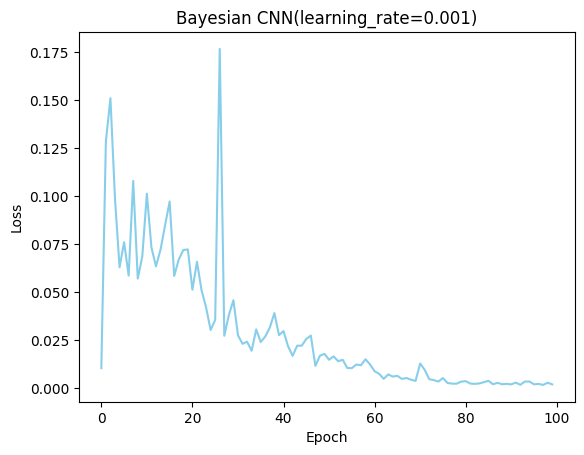

In [ ]:
BayesianCNN_model = BayesianCNN().to(device) # make an instance
y_side_raw_train[y_side_raw_train == -1] = 0
y_side_raw_train[y_side_raw_train == 1] = 2
train(BayesianCNN_model, torch.tensor(X_side_raw_train, dtype=torch.float32), torch.tensor(y_side_raw_train, dtype=torch.float32))

In [ ]:
y_side_raw_test[y_side_raw_test == 1] = 2
y_side_raw_test[y_side_raw_test == -1] = 0
y_nogo[y_nogo == 0] = 1
X_test = np.concatenate((X_side_raw_test, X_nogo_raw), axis=0)
y_test = np.concatenate((y_side_raw_test, y_nogo), axis=0)
test(BayesianCNN_model, torch.tensor(X_test, dtype=torch.float32),torch.tensor(y_test, dtype=torch.float32))

True positive rate: 83.72%
False negative rate: 38.37%
False positive rate: 16.28%
